In [20]:
versioninfo()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-4600U CPU @ 2.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)


In [1]:
using Zygote
using SparseArrays
using Flux: Dense, BatchNorm, σ, relu, softmax, logitcrossentropy, onecold, Chain, Optimise
using Flux: onehotbatch
using Flux.Data: MNIST
using StatsBase: sample, shuffle, mean
using Plots

┌ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1273
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91]
└ @ Base loading.jl:1273


In [9]:
using Pkg
my_pkgs = Pkg.installed()
println("Flux:\t", my_pkgs["Flux"])
println("Zygote:\t", my_pkgs["Zygote"])

Flux:	0.10.4
Zygote:	0.4.17


---

In [21]:
labels = MNIST.labels();
label_pool = sort(Vector(collect(Set(labels))));
y = onehotbatch(labels, label_pool);

imgs = MNIST.images();
# lighter_than(pixel, threshold) = pixel.val > threshold
# function lightness_threshold(pixel_array::Array{T, 2}, threshold) where T
#     convert.(T, lighter_than.(pixel_array, threshold))
# end
# imgs_blackenwhite = lightness_threshold.(imgs, 0.7);
# X = hcat(convert.(Array{Float32, 1}, reshape.(imgs_blackenwhite, :))...);
X = hcat(convert.(Array{Float32, 1}, reshape.(imgs, :))...);

permutation = shuffle(1:size(X, 2))
X = X[:, permutation];
y = y[:, permutation];

┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/olszewskip/.julia/packages/Flux/Fj3bt/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/olszewskip/.julia/packages/Flux/Fj3bt/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/olszewskip/.julia/packages/Flux/Fj3bt/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/olszewskip/.julia/packages/Flux/Fj3bt/src/data/mnist.jl:24


In [3]:
#rand(1:10, 4)

In [4]:
#*(size(hcat(map(index -> imgs_blackenwhite[index], rand(1:size(imgs_blackenwhite, 1), 3))...))...)

In [5]:
#hcat(map(index -> imgs_blackenwhite[index], rand(1:size(imgs_blackenwhite, 1), 4))...)

In [117]:
index_train = floor(Int, 0.6 * size(X, 2))
#index_train = min(floor(Int, 2 * size(X, 1)), index_train)
index_val = index_train + floor(Int, 0.3 * size(X, 2))
X_train = X[:, 1:index_train];
y_train = y[:, 1:index_train];
X_val = X[:, (index_train+1):index_val];
y_val = y[:, (index_train+1):index_val];
X_test = X[:, (index_val+1):end];
y_test = y[:, (index_val+1):end];

In [118]:
size(X_train)

(784, 36000)

In [119]:
mean(y_train, dims=2)

10×1 Array{Float64,2}:
 0.09783333333333334
 0.11119444444444444
 0.09961111111111112
 0.10269444444444445
 0.09705555555555556
 0.08975000000000001
 0.09844444444444445
 0.10552777777777778
 0.09780555555555556
 0.10008333333333334

In [29]:
function loss(model, X, y)
    return logitcrossentropy(model(X), y)
end

accuracy(model, X, y) = mean(onecold(softmax(model(X))) .== onecold(y));

In [120]:
update_!(opt, model, updates::Nothing) = model

function update_!(opt, model::AbstractArray, updates::AbstractArray)
    #println("Updating $(typeof(model)) with $(typeof(updates)).")
    #println(mean(abs.(updates)))
    Optimise.apply!(opt, model, updates)
    model .-= updates
    return model
end

# function update_!(opt, model::AbstractSparseArray, updates::AbstractArray, depth)
#     #println("Updating $(typeof(model)) with $(typeof(updates)).")
#     #println("inside update function 1 ", length(model.nzval))
#     #println("inside update function 1b ", length(((updates .!= 0) .&  (model .== 0)).nzval))
#     #println("inside update function 1c ", mean(updates[(updates .!= 0) .&  (model .== 0)]))
#     Optimise.apply!(opt, model, updates)
#     model .-= updates
#     #println("inside update function 2 ", length(model.nzval))
#     #dropzeros!(model)
#     #println("inside update function 3 ", length(model.nzval))
#     return model
# end

function update_!(opt, model, updates)
    for field_idx in 1:nfields(model)
        #println("Update at level $depth. Typeof model $(typeof(model)). Typeof updates $(typeof(updates))")
        update_!(opt, getfield(model, field_idx), getfield(updates, field_idx))
    end
    return model
end

update_! (generic function with 3 methods)

---

In [48]:
function get_model_dense(in, hidden_1, hidden_2, out)
    param_count = (in * hidden_1 + hidden_1) +
                  (hidden_1 * hidden_2 + hidden_2) +
                  (hidden_2 * out + out)
    println("No. parameters: $(floor(Int, param_count))")
    return Chain(
            Dense(in, hidden_1, relu),
            Dense(hidden_1, hidden_2, relu),
            Dense(hidden_2, out, relu)
           );
end

get_model_dense (generic function with 1 method)

In [49]:
model_dense = get_model_dense(size(X, 1), 90, 30, size(y, 1))

loss(model_dense, X[:, 1:32], y[:, 1:32]),
accuracy(model_dense, X[:, 1:32], y[:, 1:32])

No. parameters: 73690


(2.3181028f0, 0.125)

In [52]:
GC.gc()
model_dense = get_model_dense(size(X, 1), 90, 30, size(y, 1))
train_!(model_dense, (X_train, y_train), (X_val, y_val);
        num_epochs=100, opt=Optimise.ADAM())

No. parameters: 73690
Epoch: 1
Loss train: 1.491 Loss val: 1.551
Acc train: 0.49 Acc val: 0.457
Epoch: 2
Loss train: 0.976 Loss val: 1.039
Acc train: 0.712 Acc val: 0.689
Epoch: 3
Loss train: 0.814 Loss val: 0.919
Acc train: 0.771 Acc val: 0.728
Epoch: 4
Loss train: 0.727 Loss val: 0.855
Acc train: 0.812 Acc val: 0.764
Epoch: 5
Loss train: 0.646 Loss val: 0.789
Acc train: 0.837 Acc val: 0.789
Epoch: 6
Loss train: 0.619 Loss val: 0.777
Acc train: 0.852 Acc val: 0.799
Epoch: 7
Loss train: 0.595 Loss val: 0.77
Acc train: 0.859 Acc val: 0.801
Epoch: 8
Loss train: 0.574 Loss val: 0.758
Acc train: 0.871 Acc val: 0.806
Epoch: 9
Patience: 9/10
Loss train: 0.566 Loss val: 0.763
Acc train: 0.873 Acc val: 0.806
Epoch: 10
Patience: 8/10
Loss train: 0.554 Loss val: 0.764
Acc train: 0.875 Acc val: 0.805
Epoch: 11
Loss train: 0.545 Loss val: 0.756
Acc train: 0.876 Acc val: 0.81
Epoch: 12
Patience: 9/10
Loss train: 0.541 Loss val: 0.759
Acc train: 0.878 Acc val: 0.81
Epoch: 13
Patience: 8/10
Loss trai

In [53]:
accuracy(model_dense, X_test, y_test)

0.8114364859517214

---

In [110]:
?AbstractArray

search: AbstractArray AbstractSparseArray AbstractSparseMatrix



```
AbstractArray{T,N}
```

Supertype for `N`-dimensional arrays (or array-like types) with elements of type `T`. [`Array`](@ref) and other types are subtypes of this. See the manual section on the [`AbstractArray` interface](@ref man-interface-array).


In [42]:
sp_mul(m::AbstractSparseMatrix, x::AbstractSparseArray) = 
#Zygote.hook(dm -> dropzeros!((m .!= 0) .* dm), m) * Zygote.hook(dx -> dropzeros!((x .!= 0) .* dx), x)
Zygote.hook(dm -> (m .!= 0) .* dm, m) * Zygote.hook(dx -> (x .!= 0) .* dx, x)

struct SprAffine{S,T,F}
    W::S
    b::T
    σ::F
end

(layer::SprAffine)(x) = layer.σ.(sp_mul(layer.W, x) .+ layer.b)

function SprAffine(in::Number, out::Number, frac::AbstractFloat, σ::Function=identity)
    W_ = sprandn(Float32, out, in, frac)
    W_ ./= sqrt(in * frac)
    b_ = zeros(Float32, out)
    SprAffine(W_, b_, σ)
end

function Base.show(io::IO, layer::SprAffine)
  print(io, "SprAffine(", size(layer.W, 2), ", ", size(layer.W, 1))
  print(io, ", ", round(length(layer.W.nzval) / length(layer.W), sigdigits=6))
  layer.σ == identity || print(io, ", ", layer.σ)
  print(io, ")")
end

get_sparsity(layer::SprAffine) = length(layer.W.nzval) / length(layer.W);

In [113]:
typeof(sprandn(Float32, 4, 5, 0.1)) <: AbstractSparseMatrix

true

In [45]:
augment!(opt::Optimise.Descent, sp_arr::AbstractSparseArray) = nothing
    
function augment!(opt::Optimise.ADAM, sp_arr::AbstractSparseArray)
    # drop momentum and velocity of zeroes
    if (sp_arr in keys(opt.state))
        mt, vt, _ = opt.state[sp_arr]
        @. mt = (sp_arr != 0) * mt
        @. vt = (sp_arr != 0) * vt
    end
    return nothing
end

function augment!(opt::Optimise.Optimiser, sp_arr::AbstractSparseArray)
    augment!(opt[1], sp_arr)
end

augment!(layer, frac, opt) = nothing

function augment!(layer::SprAffine, frac::AbstractFloat, opt)
    #println(".", length(layer.W.nzval))
    # redraw frac(tion) of the layer's W(eights)
    I, J, V = findnz(layer.W)
    nz_count = length(V)
    len_augmented = floor(Int, frac * nz_count)
    len_preserved = nz_count - len_augmented
    elems = Set(zip(I, J))
    indices = sortperm(abs.(V), rev=true)[1:len_preserved]
    I = I[indices]
    J = J[indices]
    V = V[indices]
    I_ = similar(I, len_augmented)
    J_ = similar(J, len_augmented)
    V_ = similar(V, len_augmented)
    index = 1
    while index <= len_augmented
        i = sample(1:size(layer.W, 1))
        j = sample(1:size(layer.W, 2))
        if (i,j) in elems
            continue
        end
        push!(elems, (i, j))
        I_[index] = i
        J_[index] = j
        V_[index] = randn() * sqrt(size(layer.W, 1) / nz_count)
        index += 1
    end
    append!(I, I_)
    append!(J, J_)
    append!(V, V_)
    #println(".", length(layer.W.nzval))
    layer.W .= 0
    dropzeros!(layer.W)
    #println(".", length(layer.W.nzval))
    layer.W[:, :] = sparse(I, J, V, size(layer.W)...)
    augment!(opt, layer.W)
    #println(".", length(layer.W.nzval))
    return nothing
end

augment! (generic function with 5 methods)

In [46]:
mutable struct Patience{T}
    starting::T
    left::T
end
Patience(val) = Patience(val, val)

function lower!(p::Patience)
    p.left -= 1
end
function restart!(p::Patience)
    p.left = p.starting
end
nonleft(p::Patience) = p.left == 0;

function Base.show(io::IO, p::Patience)
  print(io, "Patience: $(p.left)/$(p.starting)")
end

In [4]:
Array(1:1:3)

3-element Array{Int64,1}:
 1
 2
 3

In [47]:
function train_!(model, (X_train, y_train), (X_val, y_val);
                num_epochs=1, batch_size = 32, opt=Optimise.Descent(), patience=Patience(10))
    min_loss_val = Inf32
    nth_batch = max(1, floor(Int, size(X_train, 2) ÷ (10 * batch_size)))
    #
#     I, J, _ = findnz(model[1].W)
#     nz_coordinates = Set(zip(I, J))
    #
    for epoch in 1:num_epochs
        println("Epoch: $epoch")
        permutation = shuffle(1:size(X_train, 2))
        X = X_train[:, permutation]
        y = y_train[:, permutation]
        batch_starts = 1 : batch_size : (size(X, 2) - batch_size + 1)
        for (batch_index, batch_start) in enumerate(batch_starts)
            #println("before single update 1 ", sum(model[1].W.nzval .== 0.))
            batch_loss, back = pullback(model) do m
                loss(m, X[:, batch_start:(batch_start + batch_size - 1)],
                        y[:, batch_start:(batch_start + batch_size - 1)])
            end
#             if ((batch_index - 1) % nth_batch == 0)
#                 println("Loss: $(round(batch_loss, digits=3))")
#             end
            grads = back(1)[1]
            #println("before single update 2 ", length(((grads[1][1].W .!= 0) .&  (model[1].W .== 0)).nzval))
            #println("before single update 3 ", length(((getfield(getfield(getfield(grads,1),1),1) .!=0).&(getfield(getfield(getfield(model,1),1),1).==0)).nzval))
            #println("Mean abs nz W1 ", mean(abs.(model[1].W.nzval)))
            #println("Mean abs nz dW1 ", mean(abs.(grads[1][1].W.nzval)))
            #println("5 nz dW1 ", grads[1][1].W.nzval[1:5])
            update_!(opt, model, grads)
            #println("Mean abs nz W1 after update ", mean(abs.(model[1].W.nzval)))
            #println("after single update ", length(model[1].W.nzval))
            #println(length(((grads[1][1].W .!= 0) .&  (model[1].W .== 0)).nzval))
        end
        loss_train = loss(model, X, y)
        loss_val = loss(model, X_val, y_val)
        if (loss_val < min_loss_val)
            min_loss_val = loss_val
            restart!(patience)
        else
            lower!(patience)
            println(patience)
        end
            
        println("Loss train: $(round(loss_train, digits=3)) Loss val: $(round(loss_val, digits=3))")
        acc_train = accuracy(model, X, y)
        acc_val = accuracy(model, X_val, y_val)
        println("Acc train: $(round(acc_train, digits=3)) Acc val: $(round(acc_val, digits=3))")
        
        if (nonleft(patience)) break end
        
        #println("before augment ", length(model[1].W.nzval))
        if (epoch < num_epochs)
            for layer in model.layers
                augment!(layer, 0.5, opt)
            end
#             I, J, _ = findnz(model[1].W)
#             new_nz_coordinates = Set(zip(I, J))
#             println("1st layer's new elements: ", length(setdiff(new_nz_coordinates, nz_coordinates)))
#             nz_coordinates = new_nz_coordinates
        end
        #
        #
        #println("after augment ", length(model[1].W.nzval))
        
        #println("end of epoch ", length(model[1].W.nzval))
    end
end

train_! (generic function with 1 method)

---

In [54]:
function get_model_sparse(in, hidden_0, hidden_1, out, fraction)
    param_count = (in * hidden_0 + hidden_0) * fraction +
                  (hidden_0 * hidden_1 + hidden_1) * fraction +
                  (hidden_1 * out + out)
    println("No. parameters: $(floor(Int, param_count))")
    return Chain(
            SprAffine(in, hidden_0, fraction, relu),
            Dense(hidden_0, hidden_1),
            Dense(hidden_1, out)
           );
end

get_model_sparse (generic function with 1 method)

In [61]:
function get_model_sparse(in, hidden_0, hidden_1, hidden_2, hidden_3, out, fraction)
    param_count = (in * hidden_0 + hidden_0) * fraction +
                  (hidden_0 * hidden_1 + hidden_1) * fraction +
                  (hidden_1 * hidden_2 + hidden_2)
                  (hidden_2 * hidden_3 + hidden_3)
                  (hidden_3 * out + out)
    println("No. parameters: $(floor(Int, param_count))")
    return Chain(
            SprAffine(in, hidden_0, fraction, relu),
            SprAffine(hidden_0, hidden_1, fraction, relu),
            Dense(hidden_1, hidden_2, relu),
            Dense(hidden_2, hidden_3, relu),
            Dense(hidden_3, out)
           );
end

get_model_sparse (generic function with 2 methods)

In [55]:
size(X, 1)

784

In [59]:
GC.gc()
model_sparse = get_model_sparse(size(X, 1), 90, 30, size(y, 1), 0.10)
loss(model_sparse, sparse(X[:, 1:32]), y[:, 1:32]),
accuracy(model_sparse, sparse(X[:, 1:32]), y[:, 1:32])

No. parameters: 7648


(2.3885038f0, 0.03125)

In [62]:
GC.gc()
model_sparse = get_model_sparse(size(X, 1), 90, 30, size(y, 1), 0.10)
train_!(model_sparse, (sparse(X_train), y_train), (sparse(X_val), y_val);
        num_epochs=300, opt=Optimise.ADAM())

No. parameters: 7648
Epoch: 1
Loss train: 1.661 Loss val: 1.698
Acc train: 0.601 Acc val: 0.574
Epoch: 2
Loss train: 1.028 Loss val: 1.083
Acc train: 0.76 Acc val: 0.743
Epoch: 3
Loss train: 0.652 Loss val: 0.733
Acc train: 0.837 Acc val: 0.806
Epoch: 4
Loss train: 0.507 Loss val: 0.611
Acc train: 0.873 Acc val: 0.829
Epoch: 5
Loss train: 0.427 Loss val: 0.547
Acc train: 0.898 Acc val: 0.849
Epoch: 6
Loss train: 0.362 Loss val: 0.493
Acc train: 0.902 Acc val: 0.857
Epoch: 7
Loss train: 0.31 Loss val: 0.463
Acc train: 0.925 Acc val: 0.866
Epoch: 8
Loss train: 0.282 Loss val: 0.447
Acc train: 0.929 Acc val: 0.866
Epoch: 9
Loss train: 0.257 Loss val: 0.444
Acc train: 0.934 Acc val: 0.869
Epoch: 10
Loss train: 0.233 Loss val: 0.434
Acc train: 0.936 Acc val: 0.872
Epoch: 11
Loss train: 0.212 Loss val: 0.427
Acc train: 0.939 Acc val: 0.875
Epoch: 12
Patience: 9/10
Loss train: 0.214 Loss val: 0.431
Acc train: 0.94 Acc val: 0.871
Epoch: 13
Patience: 8/10
Loss train: 0.185 Loss val: 0.432
Acc t

In [63]:
get_sparsity(model_sparse[1])

0.10120464852607709

In [64]:
accuracy(model_sparse, sparse(X_test), y_test)

0.8844974277799763

In [70]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


In [129]:
augment!(model_sparse[1], 0.3)

7821
7821
10167
7821


In [65]:
model_sparse[1].W.nzval[1:10]

10-element Array{Float32,1}:
  0.3150012  
 -0.3374149  
 -0.03892278 
 -0.12434637 
 -0.26700872 
 -0.31359023 
 -0.2645456  
  0.2522569  
  0.2845701  
  0.060026612

In [91]:
length(reshape(model_dense[1].W, :))

70560

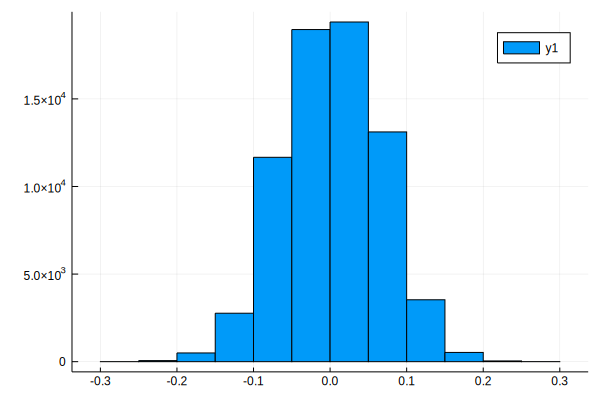

In [105]:
histogram(reshape(model_dense[1].W, :), bins=20)

In [107]:
#histogram(reshape(model_sparse[3].W, :), bins=20)

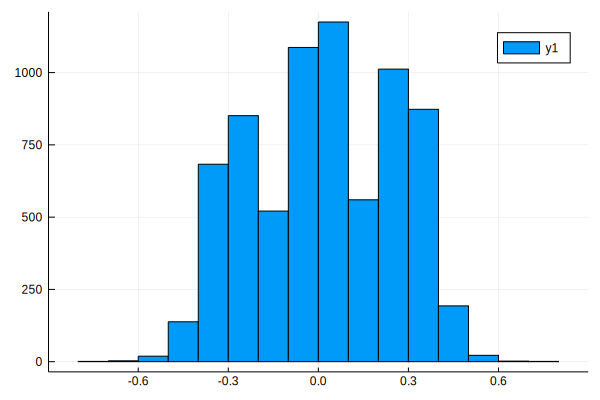

In [108]:
histogram(model_sparse[1].W.nzval, bins=20)

In [64]:
function zero_the_weights!(model)
    model[1].W[:, :] = sparse([1], [1], [13], size(model[1].W)...)
    return nothing
end

zero_the_weights! (generic function with 1 method)

In [11]:
1 in keys(Dict(1=>'a'))

true

In [135]:
spzeros()

MethodError: MethodError: no method matching spzeros()
Closest candidates are:
  spzeros(!Matched::Integer) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.3/SparseArrays/src/sparsevector.jl:108
  spzeros(!Matched::Integer, !Matched::Integer) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.3/SparseArrays/src/sparsematrix.jl:1573
  spzeros(!Matched::Type{T}, !Matched::Integer) where T at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.3/SparseArrays/src/sparsevector.jl:109
  ...

In [102]:
length(model_sparse[1].W.nzval)

0

In [103]:
model_sparse[1].W[1, 1] = 13

13

In [104]:
model_sparse[1].W

100×784 SparseMatrixCSC{Float32,Int64} with 1 stored entry:
  [1, 1]  =  13.0

In [105]:
model_sparse[1].W[:, :] = spzeros(size(model_sparse[1].W)...)
model_sparse[1].W

100×784 SparseMatrixCSC{Float32,Int64} with 1 stored entry:
  [1, 1]  =  0.0

In [2]:
model_sparse[1].W.nzval[1:10]

UndefVarError: UndefVarError: model_sparse not defined

In [ ]:
 augment!(model_sparse[1], 0.9)